# Instanciação de Parâmetros

In [88]:
import pyomo as pyo

# Número de meses
T = 36

# Parâmetros
a = 60  # Constante da demanda
b = 1/2000    # Elasticidade da demanda
variable_cost_percentage = 0.25  # Percentual de custos variáveis - Depois será utilizado no problema de otimização estocástica
variable_expenses_percentage = 0.1  # Percentual de custos variáveis
taxes_percentage = 0.1  # Percentual de impostos sobre vendas, neste caso consideramos uma empresa que opera em lucro presumido
CF = 10000    # Custo fixo mensal
DF = 10000    # Despesa fixa mensal
theta_AR = 1
theta_I = 1
theta_AP = 1

# Intervalos de preço e quantidade
P_min = 50
P_max = 50
Q_min = 3000
Q_max = 10000

# Variação inicial da NCG (exemplo)
initial_NCG = 50 * 10000 - 247500
initial_inventory = 50000

# Meses usados no cálculo do FCO futuro
months_future_FCO = 12

# Taxa de Incremento do Lucro
profit_increment_rate = 0.95

# Value at risk
alpha_var = 0.05
epsilon_var = 10000  # Valor inicial, será atualizado no loop

# Modelo Determinístico

In [89]:
from pyomo.environ import *

# Cria um modelo concreto
naive_model = model = ConcreteModel()

# Períodos
T = 36

# Variáveis de decisão
model.P = Var(range(1, T+1), bounds=(P_min, P_max))
model.Q = Var(range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos

initialize_variable_costs=[variable_cost_percentage*1.015**t for t in range(1, T+1)]

model.variable_cost_percentage = Param(range(1, T+1), initialize=lambda model, t: initialize_variable_costs[t-1], mutable=True)
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=3000)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, t):
    return model.P[t] * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, t):
    # return 0
    return revenue_rule(model, t) * model.theta_AR

def I_rule(model, t):
    # return 0
    return (model.variable_cost_percentage[t] * revenue_rule(model, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, t):
    i_t_minus_1 = I_rule(model, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, t) + model.variable_expenses_percentage * revenue_rule(model, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - model.initial_NCG

def objective_rule(model):
    t_final = T
    return sum(revenue_rule(model, t_period) -\
        model.variable_cost_percentage[t_period] * revenue_rule(model, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, t_period) - \
        model.taxes_percentage * revenue_rule(model, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, t_period) for t_period in range(t_final-months_future_FCO+1, t_final+1))

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, t):
    return (revenue_rule(model, t) -\
        model.variable_cost_percentage[t] * revenue_rule(model, t) - \
        model.variable_expenses_percentage * revenue_rule(model, t) - \
        model.taxes_percentage * revenue_rule(model, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, t)) >= 0

model.fco = Constraint(range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, t):
    return model.Q[t] <= model.Q[t-1] * 1.1 if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, t) <= 10e10
    
    return (revenue_rule(model, t) -\
        model.variable_cost_percentage[t] * revenue_rule(model, t) - \
        model.variable_expenses_percentage * revenue_rule(model, t) - \
        model.taxes_percentage * revenue_rule(model, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, t-1) -\
        model.variable_cost_percentage[t-1] * revenue_rule(model, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, t-1) - \
        model.taxes_percentage * revenue_rule(model, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

model.profit = Constraint(range(1, T+1), rule=profit_rule)

# Componentes da NCG
model.AR = Expression(range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
for t in range(1, T+1):
    print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpkm_5i3al.pyomo.lp
Reading time = 0.00 seconds
x1: 38 rows, 72 columns, 71 nonzeros
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 38 rows, 72 columns and 71 nonzeros
Model fingerprint: 0xa207f9b7
Model has 14 quadratic objective terms
Model has 70 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [3e-01, 1e+00]
  QLMatrix range   [8e+02, 2e+03]
  Objective range  [2e+05, 2e+05]
  QObjective range [8e-02, 2e+00]
  Bounds range     [1e+00, 1e+04]
  RHS range        [3e+03, 1e+11]
  QRHS range       [1e+03, 1e+11]
         Consider reformulating model or setting NumericFocus parameter
         to a

## Criação de Funções auxiliares para calcular Receita, Lucro e FCO

In [90]:
from pyomo.environ import value


def fco_period(model, t):
    return value(model.P[t] * model.Q[t] - model.variable_cost_percentage[t] * model.P[t] * model.Q[t] - model.variable_expenses_percentage * model.P[t] * model.Q[t] - model.taxes_percentage * model.P[t] * model.Q[t] - model.fix_costs - model.fix_expenses - model.NCG[t])

def revenue_period(model, t):
    return value(model.P[t] * model.Q[t])

def profit_period(model, t):
    return value(model.P[t] * model.Q[t] - model.variable_cost_percentage[t] * model.P[t] * model.Q[t] - model.variable_expenses_percentage * model.P[t] * model.Q[t] - model.taxes_percentage * model.P[t] * model.Q[t] - model.fix_costs - model.fix_expenses)

In [91]:
# Verificar se o modelo foi solucionado com sucesso
if result.solver.termination_condition == TerminationCondition.optimal:
    for t in range(1, T+1):
        # Calcula e exibe as componentes diretamente sem usar as expressões model.AR, model.I, model.AP, model.NCG
        AR_value = AR_rule(model, t)()
        I_value = I_rule(model, t)()
        AP_value = AP_rule(model, t)()
        NCG_value = NCG_rule(model, t)()
        revenue_value = revenue_rule(model, t)()

        print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
        print(f'  AR = {AR_value}, Estoque (I) = {I_value}, AP = {AP_value}, NCG = {NCG_value}')
        print(f'  NCG = AR - I - AP = {AR_value} - {I_value} - {AP_value} = {NCG_value}')
        # agora o lucro
        # print(f'  Lucro = {revenue_value - model.variable_cost_percentage * revenue_value - model.variable_expenses_percentage * revenue_value - model.taxes_percentage * revenue_value - model.fix_costs - model.fix_expenses}')
else:
    print("O modelo não encontrou uma solução ótima.")

Mês 1: Preço = 50.0, Quantidade = 3000
  AR = 150000.0, Estoque (I) = 38062.49999999999, AP = 3062.4999999999927, NCG = -67500.0
  NCG = AR - I - AP = 150000.0 - 38062.49999999999 - 3062.4999999999927 = -67500.0
Mês 2: Preço = 50.0, Quantidade = 3280.3819821703228
  AR = 164019.09910851615, Estoque (I) = 42244.144094767755, AP = 20583.55400561938, NCG = 679.6891976645275
  NCG = AR - I - AP = 164019.09910851615 - 42244.144094767755 - 20583.55400561938 = 679.6891976645275
Mês 3: Preço = 50.0, Quantidade = 3599.049086015322
  AR = 179952.45430076608, Estoque (I) = 47043.09749762169, AP = 22794.198832930542, NCG = 18521.663767792703
  NCG = AR - I - AP = 179952.45430076608 - 47043.09749762169 - 22794.198832930542 = 18521.663767792703
Mês 4: Preço = 50.0, Quantidade = 3937.152050332538
  AR = 196857.60251662688, Estoque (I) = 52234.370993642995, AP = 24877.033747683996, NCG = 20013.58679712866
  NCG = AR - I - AP = 196857.60251662688 - 52234.370993642995 - 24877.033747683996 = 20013.586797

## Gráficos de Comportamento da Solução

### Quantidade de Vendas por Período

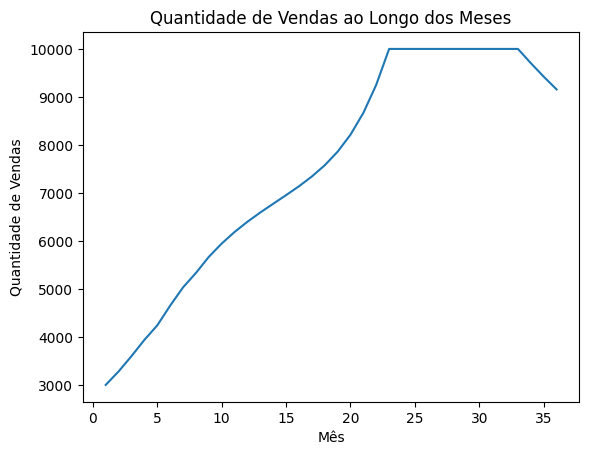

In [92]:
import matplotlib.pyplot as plt

plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

### Receita por Período

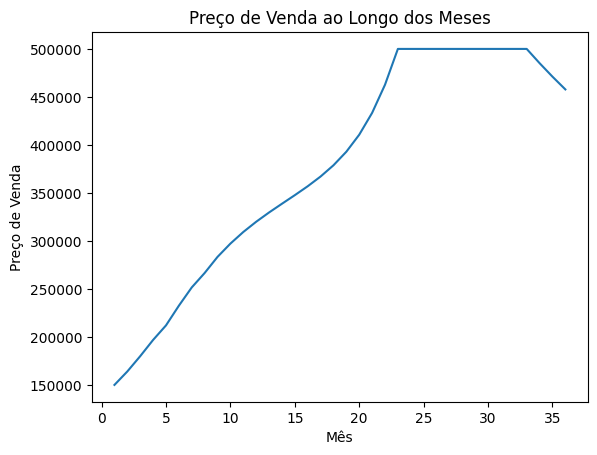

In [93]:
plt.plot(range(1, T+1), [revenue_period(model, t) for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Preço de Venda')
plt.title('Preço de Venda ao Longo dos Meses')
plt.show()

### Lucro por Período

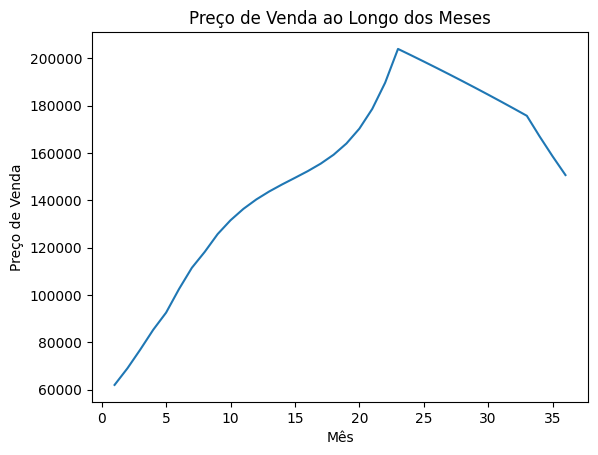

In [94]:
plt.plot(range(1, T+1), [profit_period(model, t) for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Preço de Venda')
plt.title('Preço de Venda ao Longo dos Meses')
plt.show()

### Fluxo de Caixa Operacional por Período

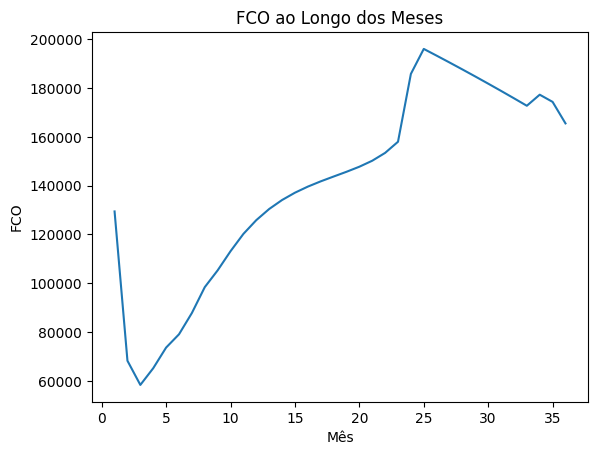

In [95]:
plt.plot(range(1, T+1), [fco_period(model, t) for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('FCO')
plt.title('FCO ao Longo dos Meses')
plt.show()

# Descobrindo possíveis variações no valor de custos variáveis com base na variação do dólar

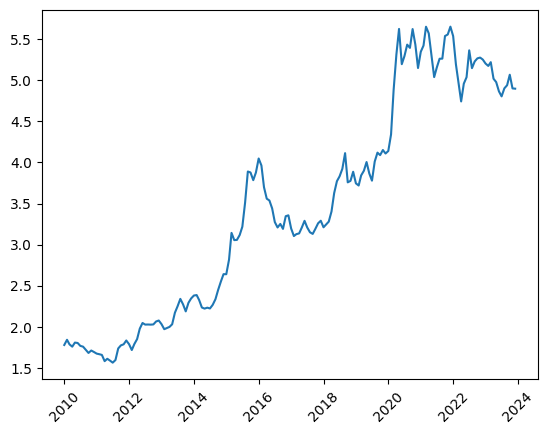

In [96]:
from currency_converter import CurrencyConverter
from datetime import datetime
from numpy import mean
import calendar
import matplotlib.pyplot as plt

c = CurrencyConverter(fallback_on_missing_rate=True)

# Pega a média do dólar mensal desde 2010
dolar_mean = []
for i in range(2010, 2024):
    for j in range(1, 13):
        _, num_days = calendar.monthrange(i, j)
        dolar_mean.append(mean([c.convert(1, 'USD', 'BRL', date=datetime(i, j, k)) for k in range(1, num_days+1)]))

# Plota o gráfico utilizando datas no eixo x
plt.plot([datetime(i, j, 1) for i in range(2010, 2024) for j in range(1, 13)], dolar_mean)
plt.xticks(rotation=45)
plt.show()


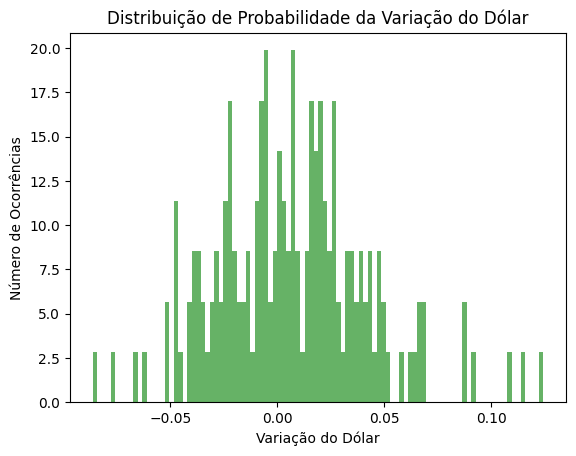

In [97]:
# Distribuição de probabilidades da variação do dólar baseado na série temporal dolar_mean
from scipy.stats import norm
import numpy as np

dolar_mean_variation = np.diff(dolar_mean)

#  Agora uma lista que pega o calor do dolar e soma com a variação
dolar_mean_variation = [(dolar_mean[i] + dolar_mean_variation[i])/dolar_mean[i] - 1 for i in range(len(dolar_mean_variation))]

# plot the histogram
plt.hist(dolar_mean_variation, bins=100, density=True, alpha=0.6, color='g')
plt.xlabel('Variação do Dólar')
plt.ylabel('Número de Ocorrências')
plt.title('Distribuição de Probabilidade da Variação do Dólar')
plt.show()


In [98]:
# Extrair os parâmetros dos dados
target_mean = np.mean(dolar_mean_variation)
target_variance = np.var(dolar_mean_variation)
target_skewness = np.mean((dolar_mean_variation - target_mean)**3) / target_variance**(3/2)
target_kurtosis = np.mean((dolar_mean_variation - target_mean)**4) / target_variance**2


In [99]:
import statsmodels.sandbox.distributions.extras as extras
import scipy.interpolate as interpolate
import scipy.stats as ss
import matplotlib.pyplot as plt  
import numpy as np

def generate_normal_four_moments(mu, sigma, skew, kurt, size=10000, sd_wide=10):
   f = extras.pdf_mvsk([mu, sigma, skew, kurt])
   x = np.linspace(mu - sd_wide * sigma, mu + sd_wide * sigma, num=500)
   y = [f(i) for i in x]
   yy = np.cumsum(y) / np.sum(y)
   inv_cdf = interpolate.interp1d(yy, x, fill_value="extrapolate")
   rr = np.random.rand(size)

   return inv_cdf(rr)

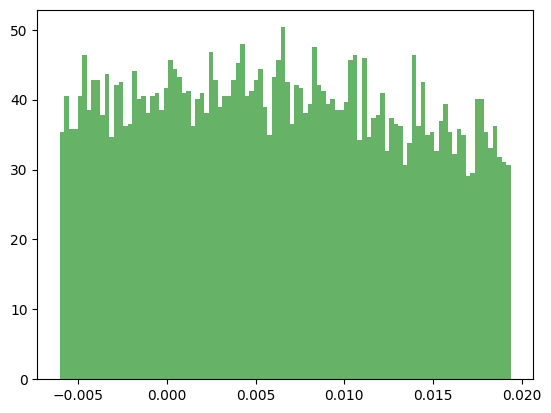

In [100]:
data = generate_normal_four_moments(mu=target_mean, sigma=target_variance, skew=target_skewness, kurt=target_kurtosis)

# plot the histogram
plt.hist(data, bins=100, density=True, alpha=0.6, color='g')

# Criando para 5 cenários
scenarios = 50
scenarios_data = []

initial_variable_costs = 0.25
dolar_affect_parameter = 1
for i in range(scenarios):
    scenario_data = []
    for j in range(1, T+1):
        if j == 1:
            scenario_data.append(initial_variable_costs)
            continue

        data = generate_normal_four_moments(mu=target_mean, sigma=target_variance, skew=target_skewness, kurt=target_kurtosis, size=1)[0]
        data = scenario_data[-1] + data * dolar_affect_parameter
        scenario_data.append(data)
    
    scenarios_data.append(scenario_data)

# Modelo Múltiplo - Avaliar se está correto...

In [101]:
from pyomo.environ import *

# Cria um modelo concreto
model = ConcreteModel()

# Períodos
T = 36

# Variáveis de decisão, agora são T * scenarios
model.P = Var(range(1, scenarios+1), range(1, T+1), bounds=(P_min, P_max))
model.Q = Var(range(1, scenarios+1), range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1])

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=3000)
for i in range(1, scenarios+1):
    model.Q[i, 1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P[i, t] * model.Q[i, t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_expenses_percentage * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG


# Função objetivo

def objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[i, t] <= model.Q[i, t-1] * 1.1 if t > 1 else model.Q[i, t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpkij3thkb.pyomo.lp
Reading time = 0.01 seconds
x1: 1900 rows, 3551 columns, 3550 nonzeros
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1900 rows, 3551 columns and 3550 nonzeros
Model fingerprint: 0x9407e006
Model has 700 quadratic objective terms
Model has 3500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [2e-01, 1e+00]
  QLMatrix range   [8e+02, 2e+03]
  Objective range  [2e+05, 2e+05]
  QObjective range [7e-04, 4e-02]
  Bounds range     [1e+00, 1e+04]
  RHS range        [3e+03, 1e+11]
  QRHS range       [1e+03, 1e+11]
         Consider reformulating model or setting NumericFocus paramete

## Criação de Funções auxiliares para calcular Receita, Lucro e FCO

In [102]:
from pyomo.environ import value


def fco_period_multiple(model, i, t):
    return value(model.P[i, t] * model.Q[i, t] - model.variable_cost_percentage[i, t] * model.P[i, t] * model.Q[i, t] - model.variable_expenses_percentage * model.P[i, t] * model.Q[i, t] - model.taxes_percentage * model.P[i, t] * model.Q[i, t] - model.fix_costs - model.fix_expenses - model.NCG[i, t])

def revenue_period_multiple(model, i, t):
    return value(model.P[i, t] * model.Q[i, t])

def profit_period_multiple(model, i, t):
    return value(model.P[i, t] * model.Q[i, t] - model.variable_cost_percentage[i, t] * model.P[i, t] * model.Q[i, t] - model.variable_expenses_percentage * model.P[i, t] * model.Q[i, t] - model.taxes_percentage * model.P[i, t] * model.Q[i, t] - model.fix_costs - model.fix_expenses)

## Gráficos de Comportamento da Solução

### Quantidade de Vendas por Período

Text(0.5, 1.0, 'Quantidade de Vendas ao Longo dos Meses Para Cada Cenário')

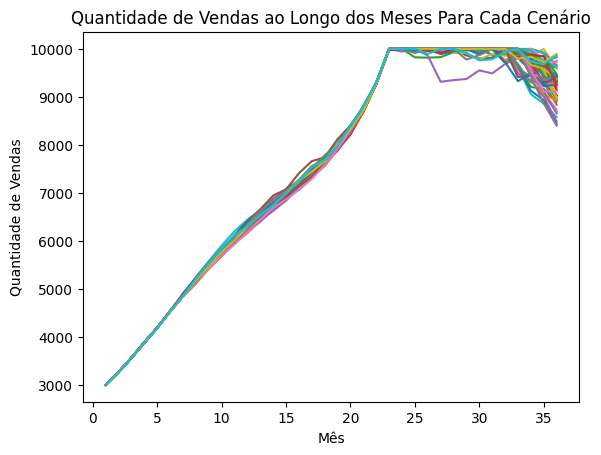

In [103]:
# plot de preço e quantidade para cada cenário
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [model.Q[i, t].value for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses Para Cada Cenário')

### Receita por Período

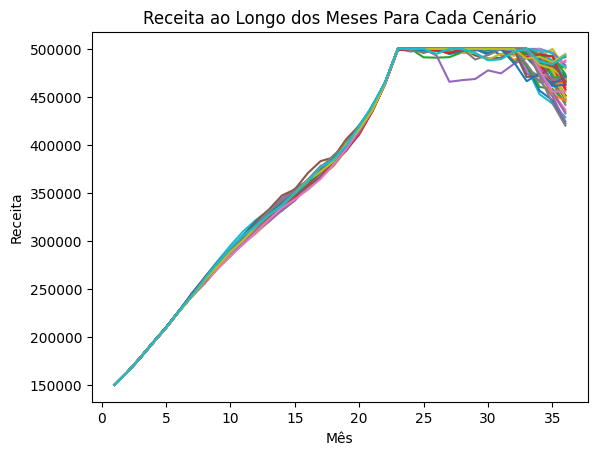

In [104]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [revenue_period_multiple(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses Para Cada Cenário')
plt.show()

### Lucro por Período

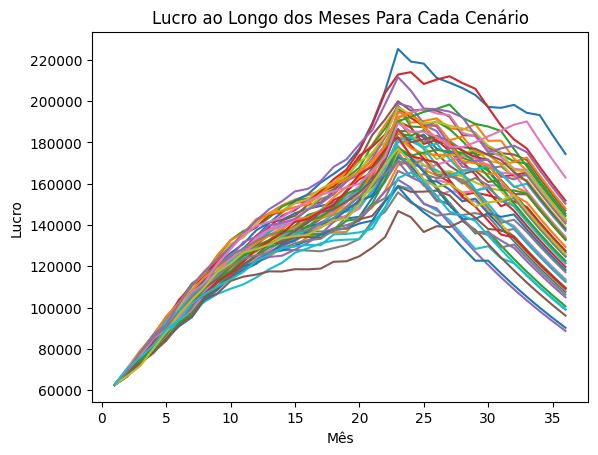

In [105]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [profit_period_multiple(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro ao Longo dos Meses Para Cada Cenário')
plt.show()

### Fluxo de Caixa Operacional por Período

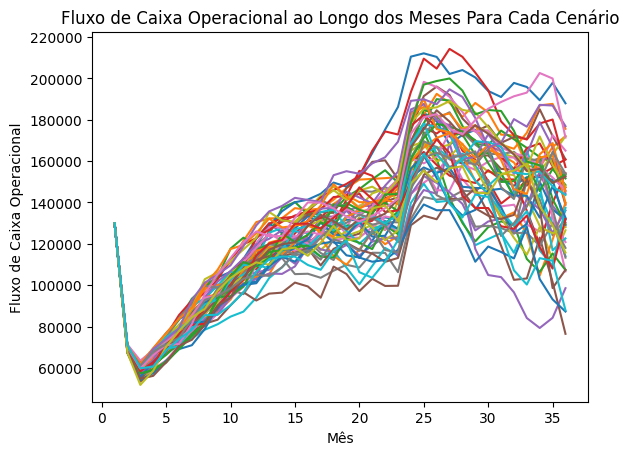

In [106]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [fco_period_multiple(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Fluxo de Caixa Operacional')
plt.title('Fluxo de Caixa Operacional ao Longo dos Meses Para Cada Cenário')
plt.show()

# Modelo Estocástico

In [107]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T = 36

# Variáveis de decisão, agora são T * scenarios
model.P = Var(range(1, scenarios+1), range(1, T+1), bounds=(P_min, P_max))
model.Q = Var(range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=3000)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P[i, t] * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_expenses_percentage * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * 1.1 if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

# Exibir os resultados
# for t in range(1, T+1):
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}')
    # print(f'Mês {t}: Preço = {model.P[t].value}, Quantidade = {model.Q[t].value}, AR = {model.AR[t].value}, Estoque = {model.I[t].value}, AP = {model.AP[t].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmp2zcadwmn.pyomo.lp
Reading time = 0.01 seconds
x1: 1900 rows, 1836 columns, 3550 nonzeros
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1900 rows, 1836 columns and 3550 nonzeros
Model fingerprint: 0x10a12b8b
Model has 700 quadratic objective terms
Model has 3500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [2e-01, 1e+00]
  QLMatrix range   [8e+02, 2e+03]
  Objective range  [2e+05, 2e+05]
  QObjective range [7e-04, 4e-02]
  Bounds range     [1e+00, 1e+04]
  RHS range        [3e+03, 1e+11]
  QRHS range       [1e+03, 1e+11]
         Consider reformulating model or setting NumericFocus paramete

## Criação de Funções auxiliares para calcular Receita, Lucro e FCO

In [108]:
from pyomo.environ import value


def fco_period(model, i, t):
    return value(model.P[i, t] * model.Q[t] - model.variable_cost_percentage[i, t] * model.P[i, t] * model.Q[t] - model.variable_expenses_percentage * model.P[i, t] * model.Q[t] - model.taxes_percentage * model.P[i, t] * model.Q[t] - model.fix_costs - model.fix_expenses - model.NCG[i, t])

def revenue_period(model, i, t):
    return value(model.P[i, t] * model.Q[t])

def profit_period(model, i, t):
    return value(model.P[i, t] * model.Q[t] - model.variable_cost_percentage[i, t] * model.P[i, t] * model.Q[t] - model.variable_expenses_percentage * model.P[i, t] * model.Q[t] - model.taxes_percentage * model.P[i, t] * model.Q[t] - model.fix_costs - model.fix_expenses)

## Quantidade de Vendas por Período

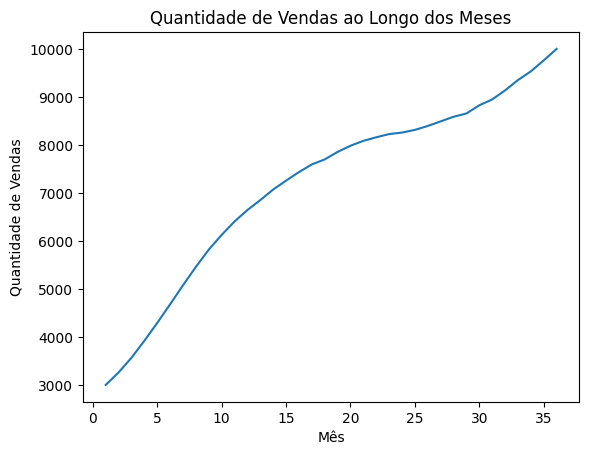

In [109]:
import matplotlib.pyplot as plt

plt.plot(range(1, T+1), [model.Q[t].value for t in range(1, T+1)])
plt.xlabel('Mês')
plt.ylabel('Quantidade de Vendas')
plt.title('Quantidade de Vendas ao Longo dos Meses')
plt.show()

## Receita por Período

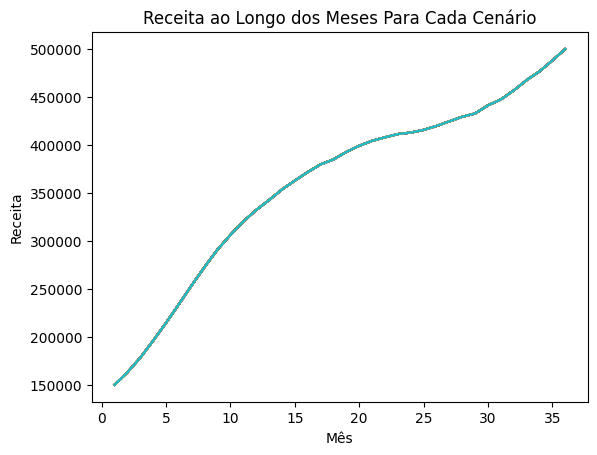

In [110]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [revenue_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Receita')
plt.title('Receita ao Longo dos Meses Para Cada Cenário')
plt.show()

## Lucro por Período

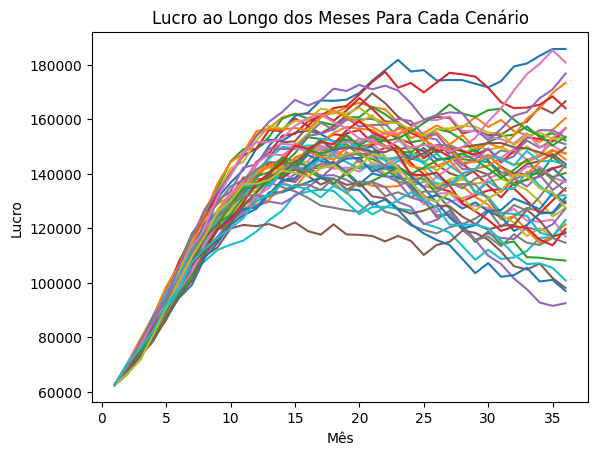

In [111]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [profit_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Lucro')
plt.title('Lucro ao Longo dos Meses Para Cada Cenário')
plt.show()

## Fluxo de Caixa Operacional por Período

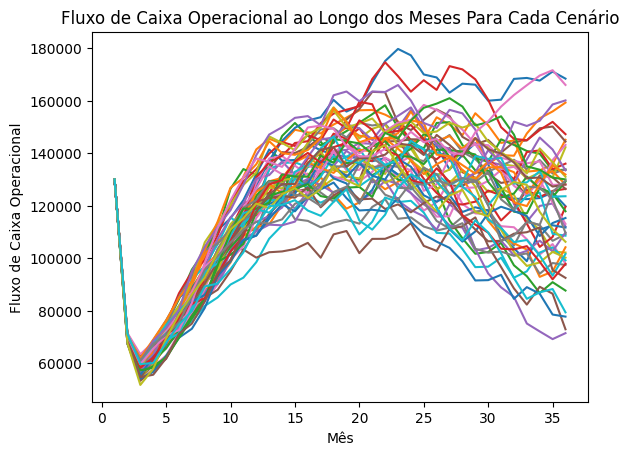

In [112]:
for i in range(1, scenarios+1):
    plt.plot(range(1, T+1), [fco_period(model, i, t) for t in range(1, T+1)], label=f'Cenário {i}')

plt.xlabel('Mês')
plt.ylabel('Fluxo de Caixa Operacional')
plt.title('Fluxo de Caixa Operacional ao Longo dos Meses Para Cada Cenário')
plt.show()

# Uso de restrição baseada em Conditional Value at Risk

In [148]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T = 36
S = range(1, scenarios+1)  # Cenários

# Variáveis de decisão, agora são T * scenarios
model.P = Var(range(1, scenarios+1), range(1, T+1), bounds=(P_min, P_max))
model.Q = Var(range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Variáveis para CVaR
model.VarDev = Var(S, within=NonNegativeReals)  # Desvio por cenário
model.VaR = Var(within=NonNegativeReals)        # Valor em Risco (VaR)
model.CVaR = Var(within=NonNegativeReals)       # CVaR

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=3000)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P[i, t] * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_expenses_percentage * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    t_final = T
    return sum(sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1))/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1)) 

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

####################################################################################################################################
# Restrições do CVaR
alpha = 0.05
epsilon = 34283990*0.05  # Limite máximo para o CVaR (valor ajustável conforme necessidade)

def fco_rule_exp(model, i):
    t_final = T
    return sum(revenue_rule(model, i, t_period) -
               model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) -
               model.variable_expenses_percentage * revenue_rule(model, i, t_period) -
               model.taxes_percentage * revenue_rule(model, i, t_period) -
               model.fix_costs - model.fix_expenses -
               NCG_rule(model, i, t_period) for t_period in range(t_final-months_future_FCO+1, t_final+1))

model.FCO = Expression(S, rule=fco_rule_exp)

# Restrições para o CVaR
# Restrição para desvio por cenário
def vardev_rule(model, i):
    return model.FCO[i] - model.VaR <= model.VarDev[i]

model.vardev_constraint = Constraint(S, rule=vardev_rule)

# Restrição para definição do CVaR
def cvar_rule(model):
    return model.VaR + (1 / (len(S) * alpha)) * sum(model.VarDev[i] for i in S) == model.CVaR

model.cvar_constraint = Constraint(rule=cvar_rule)

# Restrição de epsilon restrito (limitando o CVaR)
def epsilon_rule(model):
    return model.CVaR <= epsilon

model.epsilon_constraint = Constraint(rule=epsilon_rule)

####################################################################################################################################

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * 1.1 if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)

for i in S:
    print(f'Cenário {i}: VaR = {model.VaR.value}, CVaR = {model.CVaR.value}, VarDev = {model.VarDev[i].value}')

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmp74qii_fc.pyomo.lp
Reading time = 0.01 seconds
x1: 1902 rows, 1888 columns, 3603 nonzeros
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1902 rows, 1888 columns and 3603 nonzeros
Model fingerprint: 0x16689952
Model has 700 quadratic objective terms
Model has 3550 quadratic constraints
Coefficient statistics:
  Matrix range     [4e-01, 3e+03]
  QMatrix range    [2e-02, 1e+00]
  QLMatrix range   [1e+00, 2e+03]
  Objective range  [2e+05, 2e+05]
  QObjective range [7e-04, 4e-02]
  Bounds range     [1e+00, 1e+04]
  RHS range        [3e+03, 1e+11]
  QRHS range       [1e+03, 1e+11]
         Consider reformulating model or setting NumericFocus paramete

## Entendendo o Conditional Value at Risk

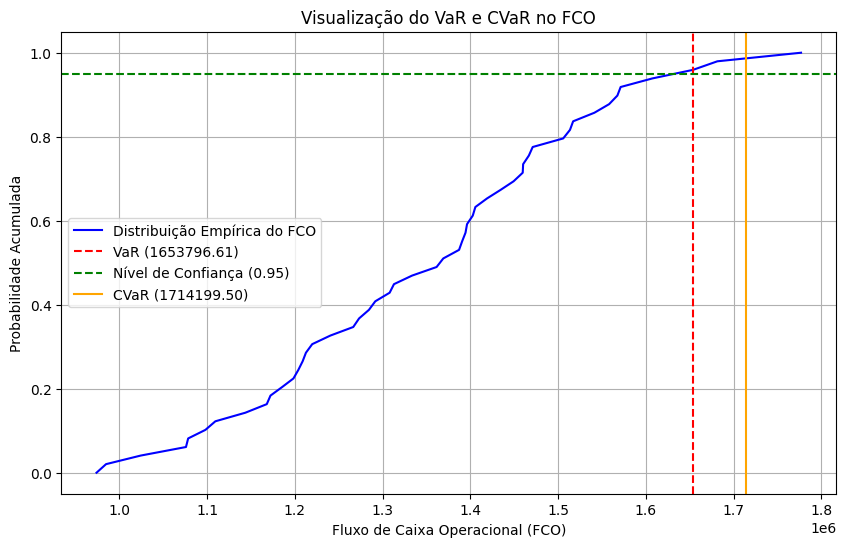

In [149]:
# Coletar os valores de FCO, VaR, e CVaR
fco_values = [value(model.FCO[i]) for i in S]
var_value = value(model.VaR)
cvar_value = value(model.CVaR)


import matplotlib.pyplot as plt
import numpy as np

# Dados
scenarios_results = list(S)
fco_values_sorted = sorted(fco_values)  # Ordenar FCO para visualização
cum_probs = np.linspace(0, 1, len(fco_values_sorted))  # Probabilidade acumulada

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(fco_values_sorted, cum_probs, label='Distribuição Empírica do FCO', color='blue')
plt.axvline(x=var_value, color='red', linestyle='--', label=f'VaR ({var_value:.2f})')
plt.axhline(y=(1-alpha), color='green', linestyle='--', label=f'Nível de Confiança ({1-alpha})')
plt.axvline(x=cvar_value, color='orange', linestyle='-', label=f'CVaR ({cvar_value:.2f})')

# Anotações
plt.title('Visualização do VaR e CVaR no FCO')
plt.xlabel('Fluxo de Caixa Operacional (FCO)')
plt.ylabel('Probabilidade Acumulada')
plt.legend()
plt.grid(True)

# Exibir
plt.show()


Value-at-Risk (95%): 1342630.496834068


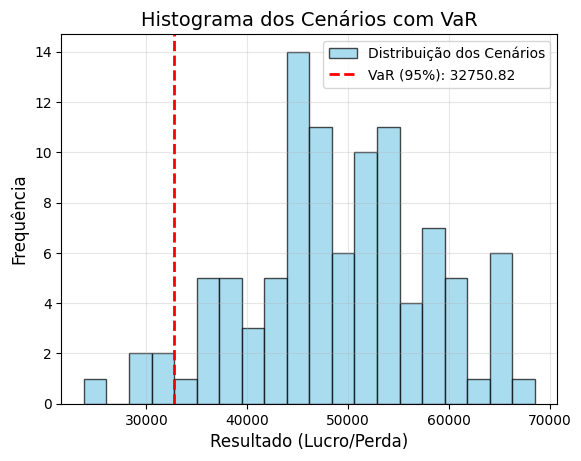

In [150]:
import numpy as np

def calculate_var(results, alpha=0.05):
    """
    Calcula o Value-at-Risk (VaR) para um conjunto de resultados.

    Parâmetros:
        results (list or numpy array): Resultados simulados (ex. lucros ou perdas) para os diferentes cenários.
        alpha (float): Nível de significância para o VaR (default é 0.05 para 95%).

    Retorna:
        float: Valor do VaR para o nível de significância dado.
    """
    # Ordena os resultados em ordem crescente
    sorted_results = np.sort(results)
    
    # Determina o índice correspondente ao percentil (1 - alpha)
    var_index = int(np.floor(alpha * len(sorted_results)))
    
    # Retorna o VaR
    return sorted_results[var_index]

def fco_last_months(model):
    t_final = T
    return sum(revenue_rule(model, i, t_period) -\
        model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_period) - \
        model.taxes_percentage * revenue_rule(model, i, t_period) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_period) for i in range(1, scenarios+1)/scenarios for t_period in range(t_final-months_future_FCO+1, t_final+1))

scenario_results = []
for i in range(1, scenarios+1):
    final_period_profit = value(objective_rule(model))
    scenario_results.append(final_period_profit)


var_95 = calculate_var(scenario_results, alpha=0.05)
print(f"Value-at-Risk (95%): {var_95}")

import numpy as np
import matplotlib.pyplot as plt

# Exemplo de resultados simulados de 100 cenários (substituir pelos resultados reais do modelo)
np.random.seed(42)  # Para reprodutibilidade
scenario_results = np.random.normal(loc=50000, scale=10000, size=100)  # Simula lucros

# Calcula o Value-at-Risk para alpha = 0.05 (95%)
alpha = 0.05
sorted_results = np.sort(scenario_results)
var_95 = sorted_results[int(np.floor(alpha * len(sorted_results)))]

# Cria o histograma
# plt.figure(figsize=(10, 6))
plt.hist(scenario_results, bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='Distribuição dos Cenários')

# Adiciona o VaR no gráfico
plt.axvline(var_95, color='red', linestyle='dashed', linewidth=2, label=f'VaR (95%): {var_95:.2f}')

# Configurações do gráfico
plt.title('Histograma dos Cenários com VaR', fontsize=14)
plt.xlabel('Resultado (Lucro/Perda)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Mostra o gráfico
plt.show()



In [151]:
from pyomo.environ import *

# Cria um modelo concreto
stochastic_model = model = ConcreteModel()

# Períodos
T = 36

# Variáveis de decisão, agora são T * scenarios
model.P = Var(range(1, scenarios+1), range(1, T+1), bounds=(P_min, P_max))
model.Q = Var(range(1, T+1), bounds=(Q_min, Q_max), within=NonNegativeReals)

# Parâmetros de custos, despesas e impostos
model.variable_expenses_percentage = Param(initialize=variable_expenses_percentage)
model.taxes_percentage = Param(initialize=taxes_percentage)
model.fix_costs = Param(initialize=CF)
model.fix_expenses = Param(initialize=DF)

# Agora variable_cost_percentage é um parâmetro que varia em cada cenário
model.variable_cost_percentage = Param(range(1, scenarios+1), range(1, T+1), initialize=lambda model, i, j: scenarios_data[i-1][j-1], mutable=True)

# Parâmetros de elasticidade da demanda
model.a = Param(initialize=a)
model.b = Param(initialize=b)

# Parâmetro de quantidade inicial de vendas
model.initial_quantity = Param(initialize=3000)
model.Q[1].fix(model.initial_quantity)

# Parâmetros de NCG
model.theta_AR = Param(initialize=theta_AR)
model.theta_I = Param(initialize=theta_I)
model.theta_AP = Param(initialize=theta_AP)
model.initial_NCG = Param(initialize=initial_NCG)
model.initial_investment = Param(initialize=initial_inventory)

# Expressões Auxiliares Gerais
def revenue_rule(model, i, t):
    return model.P[i, t] * model.Q[t]

# Expressões Auxiliares para cálculo da NCG

def AR_rule(model, i, t):
    # return 0
    return revenue_rule(model, i, t) * model.theta_AR

def I_rule(model, i, t):
    # return 0
    return (model.variable_cost_percentage[i, t] * revenue_rule(model, i, t)) * model.theta_I

#TODO: Adicionar o I aqui
def AP_rule(model, i, t):
    i_t_minus_1 = I_rule(model, i, t-1) if t > 1 else model.initial_investment
    return (I_rule(model, i, t) + model.variable_expenses_percentage * revenue_rule(model, i, t) -i_t_minus_1) * model.theta_AP

def NCG_rule(model, i, t):
    # return AR_rule(model, t) + I_rule(model, t) - AP_rule(model, t) - (AR_rule(model, t-1) + I_rule(model, t-1) - AP_rule(model, t-1) if t > 1 else model.initial_NCG)
    if t > 1:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - (AR_rule(model, i, t-1) + I_rule(model, i, t-1) - AP_rule(model, i, t-1) if t > 1 else model.initial_NCG)
    else:
        return AR_rule(model, i, t) + I_rule(model, i, t) - AP_rule(model, i, t) - model.initial_NCG

def objective_rule(model):
    t_final = T
    return sum(revenue_rule(model, i, t_final) -\
        model.variable_cost_percentage[i, t_final] * revenue_rule(model, i, t_final) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_final) - \
        model.taxes_percentage * revenue_rule(model, i, t_final) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_final) for i in range(1, scenarios+1))/scenarios

model.objective = Objective(rule=objective_rule, sense=maximize)

# Restrição de demanda
def demand_rule(model, t):
    return model.P[t] == model.a - model.b * model.Q[t]

# model.demand = Constraint(range(1, T+1), rule=demand_rule)

def fco_rule(model, i, t):
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t)) >= 0

model.fco = Constraint(range(1, scenarios+1), range(1, T+1), rule=fco_rule)

# Restrição de quantidade poder crescer unicamente 10% em cada mês
def growth_rule(model, i, t):
    return model.Q[t] <= model.Q[t-1] * 1.1 if t > 1 else model.Q[t] <= model.initial_quantity

model.growth = Constraint(range(1, scenarios+1), range(1, T+1), rule=growth_rule)

# Restrição de o lucro ser maior ou igual ao mês anterior
def profit_rule(model, i, t):
    if t <= 2:
        # return pyomo true
        return revenue_rule(model, i, t) <= 10e10
    
    return (revenue_rule(model, i, t) -\
        model.variable_cost_percentage[i, t] * revenue_rule(model, i, t) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t) - \
        model.taxes_percentage * revenue_rule(model, i, t) - \
        model.fix_costs - model.fix_expenses) >= ((revenue_rule(model, i, t-1) -\
        model.variable_cost_percentage[i, t-1] * revenue_rule(model, i, t-1) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t-1) - \
        model.taxes_percentage * revenue_rule(model, i, t-1) - \
        model.fix_costs - model.fix_expenses) * profit_increment_rate)

model.profit = Constraint(range(1, scenarios+1), range(1, T+1), rule=profit_rule)

#######################################################################################################################################
# USO DO VALUE-AT-RISK para Multiobjetivo - Restrição por epsilon restrito

scenario_results = [
    sum(revenue_rule(model, i, t_period) -
    model.variable_cost_percentage[i, t_period] * revenue_rule(model, i, t_period) -
    model.variable_expenses_percentage * revenue_rule(model, i, t_period) -
    model.taxes_percentage * revenue_rule(model, i, t_period) -
    model.fix_costs - model.fix_expenses - NCG_rule(model, i, t_period) for t_period in range(T-months_future_FCO+1, T+1))
    for i in range(1, scenarios+1)
]

def fco_last_months(model, i):
    t_final = T
    return sum(revenue_rule(model, i, t_final) -\
        model.variable_cost_percentage[i, t_final] * revenue_rule(model, i, t_final) - \
        model.variable_expenses_percentage * revenue_rule(model, i, t_final) - \
        model.taxes_percentage * revenue_rule(model, i, t_final) - \
        model.fix_costs - model.fix_expenses - \
        NCG_rule(model, i, t_final))

# Adicionar variável para o VaR
# model.VaR = Var(bounds=(None, None), initialize=0)

# # Variáveis binárias para identificar cenários abaixo do VaR
# model.u = Var(range(1, scenarios+1), within=Binary)

# # Restrição para definir se o resultado do cenário está abaixo do VaR
# # Se for menor, precisa que a variável binária seja 1
# def var_below_rule(model, i):
#     return scenario_results[i-1] <= model.VaR - (model.u[i] * 1e10)
# model.var_below_constraint = Constraint(range(1, scenarios+1), rule=var_below_rule)

# # Restrição para limitar o número de cenários abaixo do VaR (percentil α)
# alpha = 0.05
# k = int((alpha)* scenarios)  # Número mínimo de cenários abaixo do VaR
# def var_limit_rule(model):
#     return sum(model.u[i] for i in range(1, scenarios+1)) <= k
# model.var_limit_constraint = Constraint(rule=var_limit_rule)

# # Aplicar o método do ε-restrito ao VaR
# epsilon = 1000  # Ajuste do ε-restrito
# def epsilon_restriction_rule(model):
#     return model.VaR <= 10000000000
# model.epsilon_restriction = Constraint(rule=epsilon_restriction_rule)

#######################################################################################################################################

# Componentes da NCG
model.AR = Expression(range(1, scenarios+1), range(1, T+1), rule=AR_rule)
model.I = Expression(range(1, scenarios+1), range(1, T+1), rule=I_rule)
model.AP = Expression(range(1, scenarios+1), range(1, T+1), rule=AP_rule)
model.NCG = Expression(range(1, scenarios+1), range(1, T+1), rule=NCG_rule)

# Resolver o modelo
solver = SolverFactory('gurobi')
solver.options['NonConvex'] = 2
result = solver.solve(model, tee=True)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpzbxolx9w.pyomo.lp
Reading time = 0.01 seconds
x1: 1900 rows, 1836 columns, 3550 nonzeros
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1900 rows, 1836 columns and 3550 nonzeros
Model fingerprint: 0x8f082d3e
Model has 150 quadratic objective terms
Model has 3500 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [2e-01, 1e+00]
  QLMatrix range   [8e+02, 2e+03]
  Objective range  [2e+04, 2e+04]
  QObjective range [7e-01, 1e+00]
  Bounds range     [1e+00, 1e+04]
  RHS range        [3e+03, 1e+11]
  QRHS range       [1e+03, 1e+11]
         Consider reformulating model or setting NumericFocus paramete

In [152]:
for i in range(36):
    print(value(scenario_results[i]), value(model.VaR), (1 - value(model.u[i+1])))
    # print(value(model.VaR) + (1 - value(model.u[i+1])) * 1e10 >= 300000)
    print(value(scenario_results[i]), value(model.VaR) - (value(model.u[i+1]) * 1e10))

# print(value(model.VaR))

AttributeError: 'ConcreteModel' object has no attribute 'VaR'

In [ ]:
print(min([value(scenario_results[i]) for i in range(36)]))

464620.4627575143


In [ ]:
from pyomo.environ import SolverFactory

# Função para calcular o valor esperado de um modelo "Wait-and-See"
def calcular_valor_esperado(modelo, cenarios):
    solver = SolverFactory('gurobi')
    valor_esperado = 0
    
    for cenario in cenarios:
        print(f"Calculando o valor esperado para o cenário {cenario}")
        for t in range(1, T + 1):
            modelo.variable_cost_percentage[t] = cenario[t-1]

        resultado = solver.solve(modelo, tee=False)
        valor_esperado += modelo.objective()
    
    return valor_esperado/len(cenarios)

# Cálculo do valor estocástico
solver = SolverFactory('gurobi')
resultado_stochastic = solver.solve(stochastic_model, tee=True)
z = stochastic_model.objective()
# z = resultado_stochastic.Solution.Objective['value']

# Definir os cenários (substitua pelos seus cenários reais)

cenarios = [[scenarios_data[i][j] for j in range(T)] for i in range(scenarios)]

# Para o naive_model, fixar todos os Q e P
# for t in range(1, T+1):
#     naive_model.Q[t].fix(naive_model.Q[t].value)

# Cálculo do valor "Wait-and-See" para cada cenário
z_ws = calcular_valor_esperado(naive_model, cenarios)

# Cálculo do EVPI
evpi = z - z_ws

print(f"Valor Estocástico (z): {z}")
print(f"Valor Wait-and-See (z_ws): {z_ws}")
print(f"Expected Value of Perfect Information (EVPI): {evpi}")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-13
Read LP format model from file /var/folders/6n/ffgn982n58v3d24kq1527mc80000gn/T/tmpx8972n56.pyomo.lp
Reading time = 0.02 seconds
x1: 1902 rows, 1887 columns, 3601 nonzeros
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1902 rows, 1887 columns and 3601 nonzeros
Model fingerprint: 0xf35f15bf
Model has 150 quadratic objective terms
Model has 3550 quadratic constraints
Variable types: 1837 continuous, 50 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  QMatrix range    [1e-02, 1e+00]
  QLMatrix range   [1e+00, 1e+10]
  Objective range  [2e+04, 2e+04]
  QObjective range [6e-01, 1e+00]
  Bounds range     [1e+00, 1e+04]
  RHS range        [2e+00, 1e+11]
  QRHS range       [1e+03, 1e+11]
         Consider reformulating model or setting 

In [ ]:
from pyomo.environ import SolverFactory

# Função para calcular o valor esperado de um modelo "Wait-and-See"
def calcular_valor_esperado(modelo, cenarios):
    solver = SolverFactory('gurobi')
    valor_esperado = 0
    
    for cenario in cenarios:
        for t in range(1, T + 1):
            modelo.variable_cost_percentage[t] = cenario[t-1]

        resultado = solver.solve(modelo, tee=False)
        valor_esperado += modelo.objective()

        print("O objetivo atual é: ", modelo.objective())
    
    return valor_esperado/len(cenarios)

# Cálculo do valor estocástico
solver = SolverFactory('gurobi')
resultado_stochastic = solver.solve(stochastic_model, tee=False)
z = stochastic_model.objective()
# z = resultado_stochastic.Solution.Objective['value']

# Definir os cenários (substitua pelos seus cenários reais)

cenarios = [[scenarios_data[i][j] for j in range(T)] for i in range(scenarios)]

# Para o naive_model, fixar todos os Q e P
for t in range(1, T+1):
    naive_model.Q[t].fix(naive_model.Q[t].value)

# Cálculo do valor "Wait-and-See" para cada cenário
z_ws = calcular_valor_esperado(naive_model, cenarios)

# Cálculo do EVPI
evpi = z - z_ws

print(f"Valor Estocástico (z): {z}")
print(f"Valor Wait-and-See (z_ws): {z_ws}")
print(f"EVPI: {z_ws - z} - {(z_ws - z)/z * 100}%")


model.name="unknown";
    - termination condition: infeasible
    - message from solver: Model was proven to be infeasible.
O objetivo atual é:  1613074.7897106127
O objetivo atual é:  2045444.532920175
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Model was proven to be infeasible.
O objetivo atual é:  2134785.646830578
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Model was proven to be infeasible.
O objetivo atual é:  1808133.2861798524
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Model was proven to be infeasible.
O objetivo atual é:  1763672.4593189768
O objetivo atual é:  1871558.9811466394
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Model was proven to be infeasible.
O objetivo atual é:  1745954.928300202
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Model was prov

# Testes de EVPI